# Regression Decision Tree 

## Import Modules

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

## Importing data

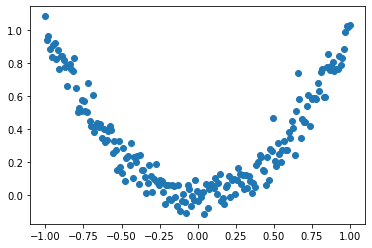

In [18]:
# First tried with the parabola, but had issues in the concatenate inside the fit
N = 200
X = np.linspace(-1,1,N)
Y = X**2 + np.random.normal(0, 0.07, N)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
plt.scatter(X,Y)
plt.show()


## Node class

A small class just containing a constructor, which will basically describe the nodes of our tree. 

In [19]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # Decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

## Tree class

The actual algorithm, which will contain a tree building part, entropy calculation etc.

In [20]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        
        # extracts the number of samples and features 
        num_samples, num_features = np.shape(X)
        best_split = {}
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            # check if information gain is positive
            if best_split["var_red"]>0:
                
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split 
        returns a dictionary, indeed best_split dicsionary is defined at the beginning and max info gain is initializeed 
        as negatve infinity, since we want to maximise the information gain, and to find that we need to use a  number
        bigger that any other number '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node.
        
        For regression, leaf node is computed by the mean of the values in the predictor column, while
        for classificaiton, the leaf node is computed by majority rule.
        
        '''
        
        val = np.mean(Y) # mean class contained in that particular node 
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            
            
            
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        # concatenate x and y to create the dataset
        
        #dataset = np.concatenate((X, Y), axis=1)
        dataset = np.column_stack((X,Y))
        #dataset = np.hstack((X,Y))
        
        
        # call the build tree function
        #root node will be returned by the build tree fct and it will be stored in self.root
        
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

## Train-Test split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [10]:
X_train.ndim

2

In [11]:
Y_train.ndim

2

## Fit the model

In [22]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train,Y_train)
regressor.print_tree()

X_0 <= -0.6884422110552764 ? 0.03458824762992681
 left:X_0 <= -0.8090452261306533 ? 0.01929375721814175
  left:X_0 <= -0.9798994974874372 ? 0.004013629786929889
    left:X_0 <= -1.0 ? 0.003865248393485494
        left:1.085833303176834
        right:0.9539484375906541
    right:X_0 <= -0.8994974874371859 ? 0.0016771403348342932
        left:0.8726775384477471
        right:0.7907717307212058
  right:X_0 <= -0.728643216080402 ? 0.0016581484445158758
    left:X_0 <= -0.7989949748743719 ? 0.0017059225860773769
        left:0.648487819058575
        right:0.5304551917065081
    right:0.6452637829184332
 right:X_0 <= 0.6381909547738693 ? 0.05369148047116465
  left:X_0 <= -0.5175879396984925 ? 0.006154907439842759
    left:X_0 <= -0.5678391959798995 ? 0.003081163899175117
        left:0.3874220291476759
        right:0.2671541915978745
    right:X_0 <= 0.3668341708542713 ? 0.0075424148971991595
        left:0.06227309123835859
        right:0.2673918946300289
  right:X_0 <= 0.839195979899497

## Test the model

In [23]:
Y_pred = regressor.predict(X_test) 

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mse = mean_squared_error(Y_test, Y_pred)

print("RMSE: {:.2f}".format(rmse))
print("MSE: {:.2f}".format(mse))

RMSE: 0.11
MSE: 0.01


## Let's test the tree on another dataset: the diabetes dataset

In [24]:
from sklearn.datasets import load_diabetes
from sklearn import model_selection
from sklearn.model_selection import train_test_split

diabetes = load_diabetes()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.30, random_state=0)


## Fit the model

In [25]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train,y_train)
regressor.print_tree()

X_8 <= 0.0213108465682448 ? 1997.0530908365454
 left:X_2 <= 0.00457216660300077 ? 979.3019065841804
  left:X_6 <= 0.0191869970174533 ? 307.072122073178
    left:X_8 <= -0.0439854025655911 ? 377.94398428731756
        left:86.25
        right:130.21212121212122
    right:X_6 <= 0.159089233572762 ? 114.52447734192015
        left:81.74242424242425
        right:170.0
  right:X_3 <= 0.0218723549949558 ? 1195.670590087273
    left:X_6 <= -0.0029028298070691 ? 538.5354409143329
        left:164.72727272727272
        right:116.16666666666667
    right:X_8 <= -0.0332487872476258 ? 1883.3944384771457
        left:85.0
        right:232.8421052631579
 right:X_2 <= 0.0121168511201671 ? 1246.314661475798
  left:X_3 <= 0.0563010619323185 ? 768.6915807836399
    left:X_7 <= 0.0712099797536354 ? 627.3026595391461
        left:159.0909090909091
        right:239.75
    right:X_2 <= -0.0503962491649252 ? 1740.0208333333333
        left:189.0
        right:285.3333333333333
  right:X_5 <= 0.0215459602

### Let's test the model

In [26]:
Y_pred = regressor.predict(X_test) 

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
mse = mean_squared_error(y_test, Y_pred)

print("RMSE: {:.2f}".format(rmse))
print("MSE: {:.2f}".format(mse))

RMSE: 67.13
MSE: 4506.96
